In [1]:
from pathlib import Path
import pandas as pd
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler, MaxAbsScaler, RobustScaler
from sklearn.mixture import BayesianGaussianMixture
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.ensemble import IsolationForest
from umap import UMAP
from scipy import stats
from sklearn.preprocessing import LabelEncoder
import hdbscan
from datetime import datetime

/Users/adityabehal/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/adityabehal/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/adityabehal/opt/anaconda3/envs/homl3/lib/pyth

In [2]:
!pwd

/Users/adityabehal/Documents/RPI/Junior/Summer/UCSF/Shirvalkar-Lab/clustering


In [3]:
pt_id = "RCS04"

In [4]:
IMAGES_PATH = Path() / "data" / pt_id
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [5]:
pt_pain_path = Path() / "data" / pt_id / (pt_id + "_pain_filtered.xlsx")
pt_sleep_path = Path() / "data" / pt_id / (pt_id + "_sleepStageLogInfo_20190130_20230530.csv")
pt_wear_path = Path() / "data" / pt_id / (pt_id + "_fitbitWearTimeViaHR_20190130_20230530.csv")

pt_pain = pd.read_excel(pt_pain_path)
pt_sleep = pd.read_csv(pt_sleep_path)
pt_wear = pd.read_csv(pt_wear_path)

In [6]:
# convert a StartTime to a relative start time (see the cell below)
def convert_to_fractional_time(time_string):
    time_parts = time_string.split(' ')[-2].split(':')
    hours = int(time_parts[0])
    minutes = int(time_parts[1])
    seconds = int(time_parts[2])
    am_pm = time_string.split(' ')[-1].strip().upper()

    if am_pm == 'PM' and hours != 12:
        hours += 12
    elif am_pm == 'AM' and hours == 12:
        hours = 0

    fractional_hours = hours + (minutes / 60.0) + (seconds / 3600.0)

    if fractional_hours >= 24:
        fractional_hours -= 24

    return fractional_hours

In [7]:
# extract just the Day from the StartTime field and store it in a separate column
pt_sleep["Day"] = pt_sleep["StartTime"].str.split().str[0]

# binarize SleepDataType --> classic = 0, stages = 1
pt_sleep["SleepDTBinary"] = LabelEncoder().fit_transform(pt_sleep["SleepDataType"])

# we'll also convert times in StartTime to relative start times 
# (i.e. ignore the day and just look at the HH:MM:SS AM/PM and convert it into a number ranging from 0 - 24 hours)
pt_sleep["RelativeStartTime"] = pt_sleep["StartTime"].apply(convert_to_fractional_time)

# get rid of days with 0 perrcent wear time
pt_wear = pt_wear[pt_wear["PercentageWearTime"] != 0]

# merge sleep and wear dataframes with SQL-like inner join
pt_sleep_wear = pd.merge(pt_sleep, pt_wear, on="Day", how="inner")

# shorten some column names to improve plotting aesthetics 
pt_sleep_wear.columns = pt_sleep_wear.columns.str.replace("Classic", "C-")
pt_sleep_wear.columns = pt_sleep_wear.columns.str.replace("Stages", "S-")

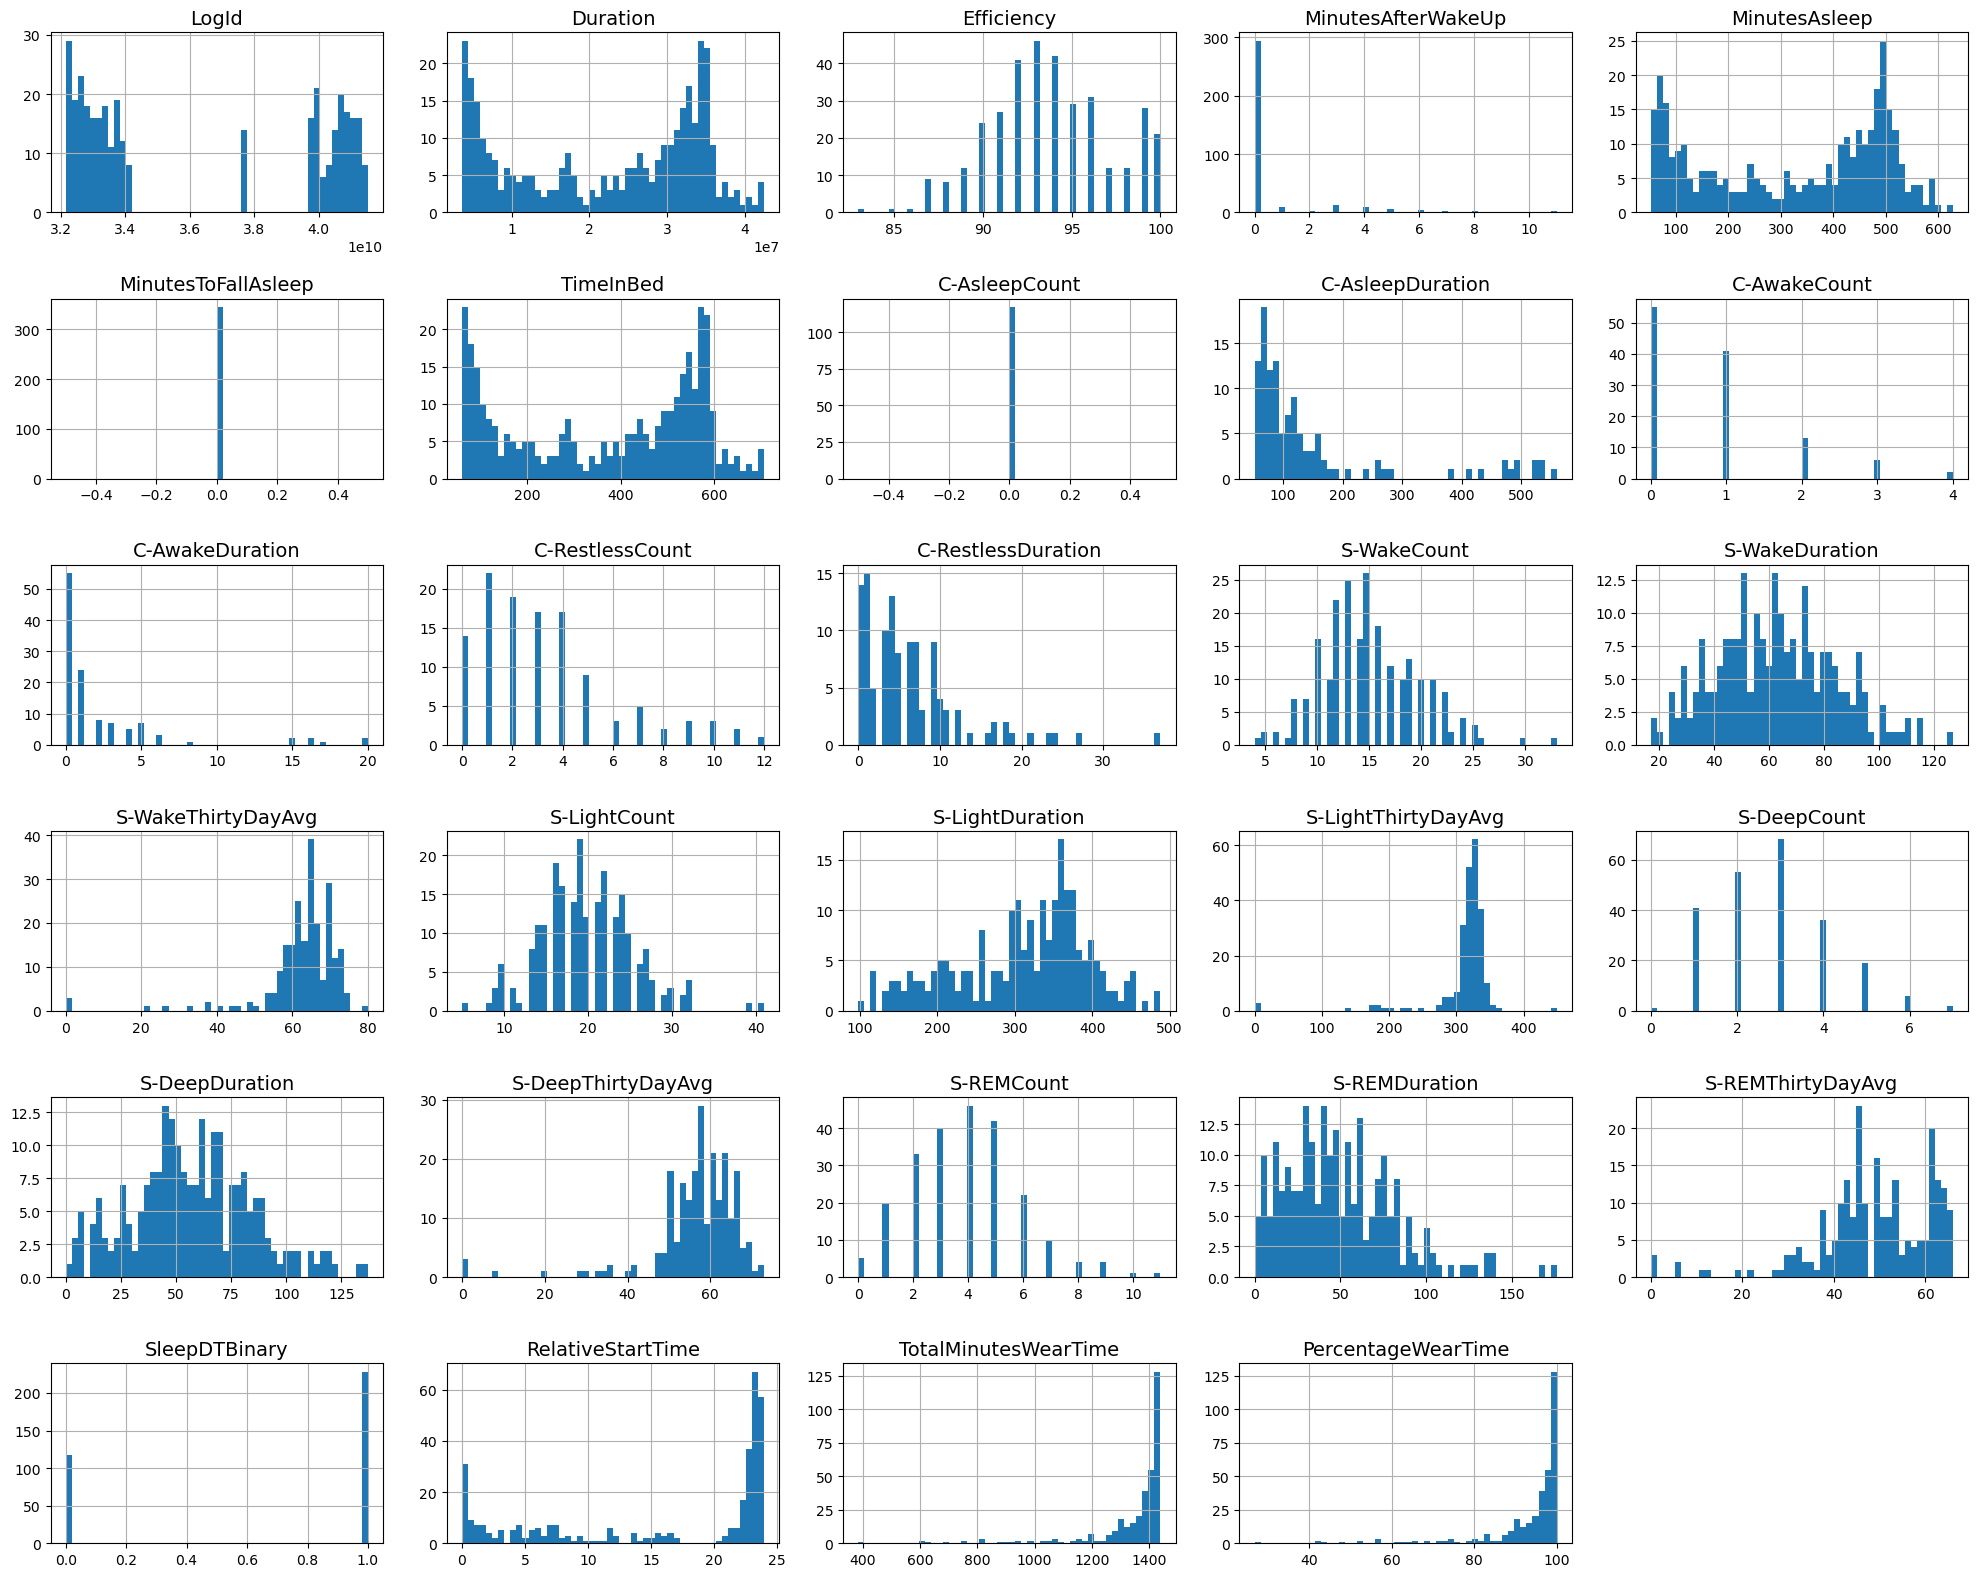

In [8]:
# the next 5 lines define the default font sizes
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

# let's get histograms of the data variables
pt_sleep_wear.hist(bins=50, figsize=(20, 16))
plt.tight_layout()
save_fig((pt_id + "_sleep_histogram_plots"))
plt.show()

In [9]:
# let's get a sense of the number and data types of the dataframe columns
pt_sleep_wear.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 345 entries, 0 to 344
Data columns (total 34 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   LogId                 345 non-null    int64  
 1   StartTime             345 non-null    object 
 2   Duration              345 non-null    int64  
 3   Efficiency            345 non-null    int64  
 4   IsMainSleep           345 non-null    bool   
 5   SleepDataType         345 non-null    object 
 6   MinutesAfterWakeUp    345 non-null    int64  
 7   MinutesAsleep         345 non-null    int64  
 8   MinutesToFallAsleep   345 non-null    int64  
 9   TimeInBed             345 non-null    int64  
 10  C-AsleepCount         117 non-null    float64
 11  C-AsleepDuration      117 non-null    float64
 12  C-AwakeCount          117 non-null    float64
 13  C-AwakeDuration       117 non-null    float64
 14  C-RestlessCount       117 non-null    float64
 15  C-RestlessDuration    1

In [10]:
# we'll consider data as reliable if the wear time for that day was more than 80 percent and if it was auto-detected
pt_sleep_wear = pt_sleep_wear[pt_sleep_wear["PercentageWearTime"] >= 80]
pt_sleep_wear = pt_sleep_wear[pt_sleep_wear["SleepLogType"] == "auto_detected"]

In [11]:
# let's get a sense of our filtered data by looking at the first 5 rows
pt_sleep_wear.head()

LogId             StartTime  Duration  Efficiency  IsMainSleep  \
203  39767782648  1/4/2023 10:09:00 PM  38820000          94         True   
204  39767782649  1/5/2023 11:14:00 PM   3840000          94        False   
205  39767782650   1/6/2023 1:29:00 AM  22920000          88         True   
206  39767782651  1/6/2023 11:06:00 PM  34860000          92         True   
207  39767782652  1/7/2023 10:18:30 PM   5880000          93        False   

    SleepDataType  MinutesAfterWakeUp  MinutesAsleep  MinutesToFallAsleep  \
203        stages                   0            567                    0   
204       classic                   0             60                    0   
205        stages                   0            340                    0   
206        stages                   0            506                    0   
207       classic                   0             91                    0   

     TimeInBed  ...  S-DeepThirtyDayAvg  S-REMCount  S-REMDuration  \
203        647  ...                 0.0         4.0           56.0   
204         64  ...                 NaN         NaN            NaN   
205        382  ...                62.0         2.0           15.0   
206        581  ...                72.0         3.0           18.0   
207         98  ...                 NaN         NaN            NaN   

     S-REMThirtyDayAvg   SleepLogType       Day  SleepDTBinary  \
203                0.0  auto_detected  1/4/2023              1   
204                NaN  auto_detected  1/5/2023              0   
205               56.0  auto_detected  1/6/2023              1   
206               36.0  auto_detected  1/6/2023              1   
207                NaN  auto_detected  1/7/2023              0   

     RelativeStartTime  TotalMinutesWearTime  PercentageWearTime  
203          22.150000                  1241           86.180556  
204          23.233333                  1399           97.152778  
205           1.483333                  1440          100.000000  
206          23.100000                  1440          100.000000  
207          22.308333                  1438           99.861111  

[5 rows x 34 columns]

In [12]:
# let's get a sense of the number and data types of the filtered dataframe columns
pt_sleep_wear.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 136 entries, 203 to 344
Data columns (total 34 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   LogId                 136 non-null    int64  
 1   StartTime             136 non-null    object 
 2   Duration              136 non-null    int64  
 3   Efficiency            136 non-null    int64  
 4   IsMainSleep           136 non-null    bool   
 5   SleepDataType         136 non-null    object 
 6   MinutesAfterWakeUp    136 non-null    int64  
 7   MinutesAsleep         136 non-null    int64  
 8   MinutesToFallAsleep   136 non-null    int64  
 9   TimeInBed             136 non-null    int64  
 10  C-AsleepCount         30 non-null     float64
 11  C-AsleepDuration      30 non-null     float64
 12  C-AwakeCount          30 non-null     float64
 13  C-AwakeDuration       30 non-null     float64
 14  C-RestlessCount       30 non-null     float64
 15  C-RestlessDuration   

In [13]:
# let's get summary statistics of the filtered dataframe columns
pt_sleep_wear.describe()

LogId      Duration  Efficiency  MinutesAfterWakeUp  \
count  1.360000e+02  1.360000e+02  136.000000          136.000000   
mean   4.056579e+10  2.535441e+07   93.066176            0.595588   
std    5.326068e+08  1.073357e+07    3.045828            1.891026   
min    3.976778e+10  3.660000e+06   86.000000            0.000000   
25%    4.001065e+10  1.855500e+07   91.000000            0.000000   
50%    4.060849e+10  2.961000e+07   93.000000            0.000000   
75%    4.100054e+10  3.363000e+07   94.250000            0.000000   
max    4.152957e+10  4.248000e+07  100.000000           11.000000   

       MinutesAsleep  MinutesToFallAsleep   TimeInBed  C-AsleepCount  \
count     136.000000                136.0  136.000000           30.0   
mean      371.323529                  0.0  422.573529            0.0   
std       154.401059                  0.0  178.892752            0.0   
min        60.000000                  0.0   61.000000            0.0   
25%       280.500000                  0.0  309.250000            0.0   
50%       431.000000                  0.0  493.500000            0.0   
75%       491.750000                  0.0  560.500000            0.0   
max       587.000000                  0.0  708.000000            0.0   

       C-AsleepDuration  C-AwakeCount  ...  S-DeepCount  S-DeepDuration  \
count         30.000000     30.000000  ...   106.000000      106.000000   
mean         159.533333      0.833333  ...     2.839623       58.056604   
std          143.889501      0.949894  ...     1.310302       23.974920   
min           60.000000      0.000000  ...     1.000000        4.000000   
25%           75.750000      0.000000  ...     2.000000       40.500000   
50%           97.000000      1.000000  ...     3.000000       57.000000   
75%          151.250000      1.000000  ...     4.000000       74.000000   
max          534.000000      3.000000  ...     7.000000      137.000000   

       S-DeepThirtyDayAvg  S-REMCount  S-REMDuration  S-REMThirtyDayAvg  \
count          106.000000  106.000000     106.000000         106.000000   
mean            58.867925    4.245283      54.245283          54.594340   
std              7.614617    1.916402      30.043718          11.157554   
min              0.000000    0.000000       0.000000           0.000000   
25%             56.000000    3.000000      31.250000          46.000000   
50%             58.000000    4.000000      52.000000          60.000000   
75%             64.000000    5.000000      73.750000          63.000000   
max             73.000000   11.000000     138.000000          66.000000   

       SleepDTBinary  RelativeStartTime  TotalMinutesWearTime  \
count     136.000000         136.000000            136.000000   
mean        0.779412          17.105637           1400.132353   
std         0.416176           9.195781             62.223350   
min         0.000000           0.041667           1189.000000   
25%         1.000000           7.212500           1389.000000   
50%         1.000000          22.783333           1433.000000   
75%         1.000000          23.391667           1440.000000   
max         1.000000          23.966667           1440.000000   

       PercentageWearTime  
count          136.000000  
mean            97.231413  
std              4.321066  
min             82.569444  
25%             96.458333  
50%             99.513889  
75%            100.000000  
max            100.000000  

[8 rows x 29 columns]

In [14]:
# code adapted from https://stackoverflow.com/questions/48139899/correlation-matrix-plot-with-coefficients-on-one-side-scatterplots-on-another
# we will use kendall tau rank correlation as it more robust to outliers than spearman's rank correlation

def corrdot(*args, **kwargs):
    corr_r = args[0].corr(args[1], 'kendall')
    corr_text = f"{corr_r:2.2f}".replace("0.", ".")
    ax = plt.gca()
    ax.set_axis_off()
    marker_size = abs(corr_r) * 10000
    ax.scatter([.5], [.5], marker_size, [corr_r], alpha=0.6, cmap="coolwarm",
               vmin=-1, vmax=1, transform=ax.transAxes)
    font_size = abs(corr_r) * 40 + 5
    ax.annotate(corr_text, [.5, .5,],  xycoords="axes fraction",
                ha='center', va='center', fontsize=font_size)

def corrfunc(x, y, **kws):
    r, p = stats.kendalltau(x, y)
    p_stars = ''
    if p <= 0.05:
        p_stars = '*'
    if p <= 0.01:
        p_stars = '**'
    if p <= 0.001:
        p_stars = '***'
    ax = plt.gca()
    ax.annotate(p_stars, xy=(0.65, 0.6), xycoords=ax.transAxes,
                color='red', fontsize=70)
    
def plotcorr(data):
    sns.set(style='white', font_scale=1.6)
    g = sns.PairGrid(data, aspect=1.4, diag_sharey=False)
    g.map_lower(sns.regplot, lowess=True, ci=False, line_kws={'color': 'black'})
    g.map_diag(sns.distplot, kde_kws={'color': 'black'})
    g.map_upper(corrdot)
    g.map_upper(corrfunc)

/Users/adityabehal/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/Users/adityabehal/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/Users/adityabehal/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/Users/adityabehal/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/Users/adityabehal/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.

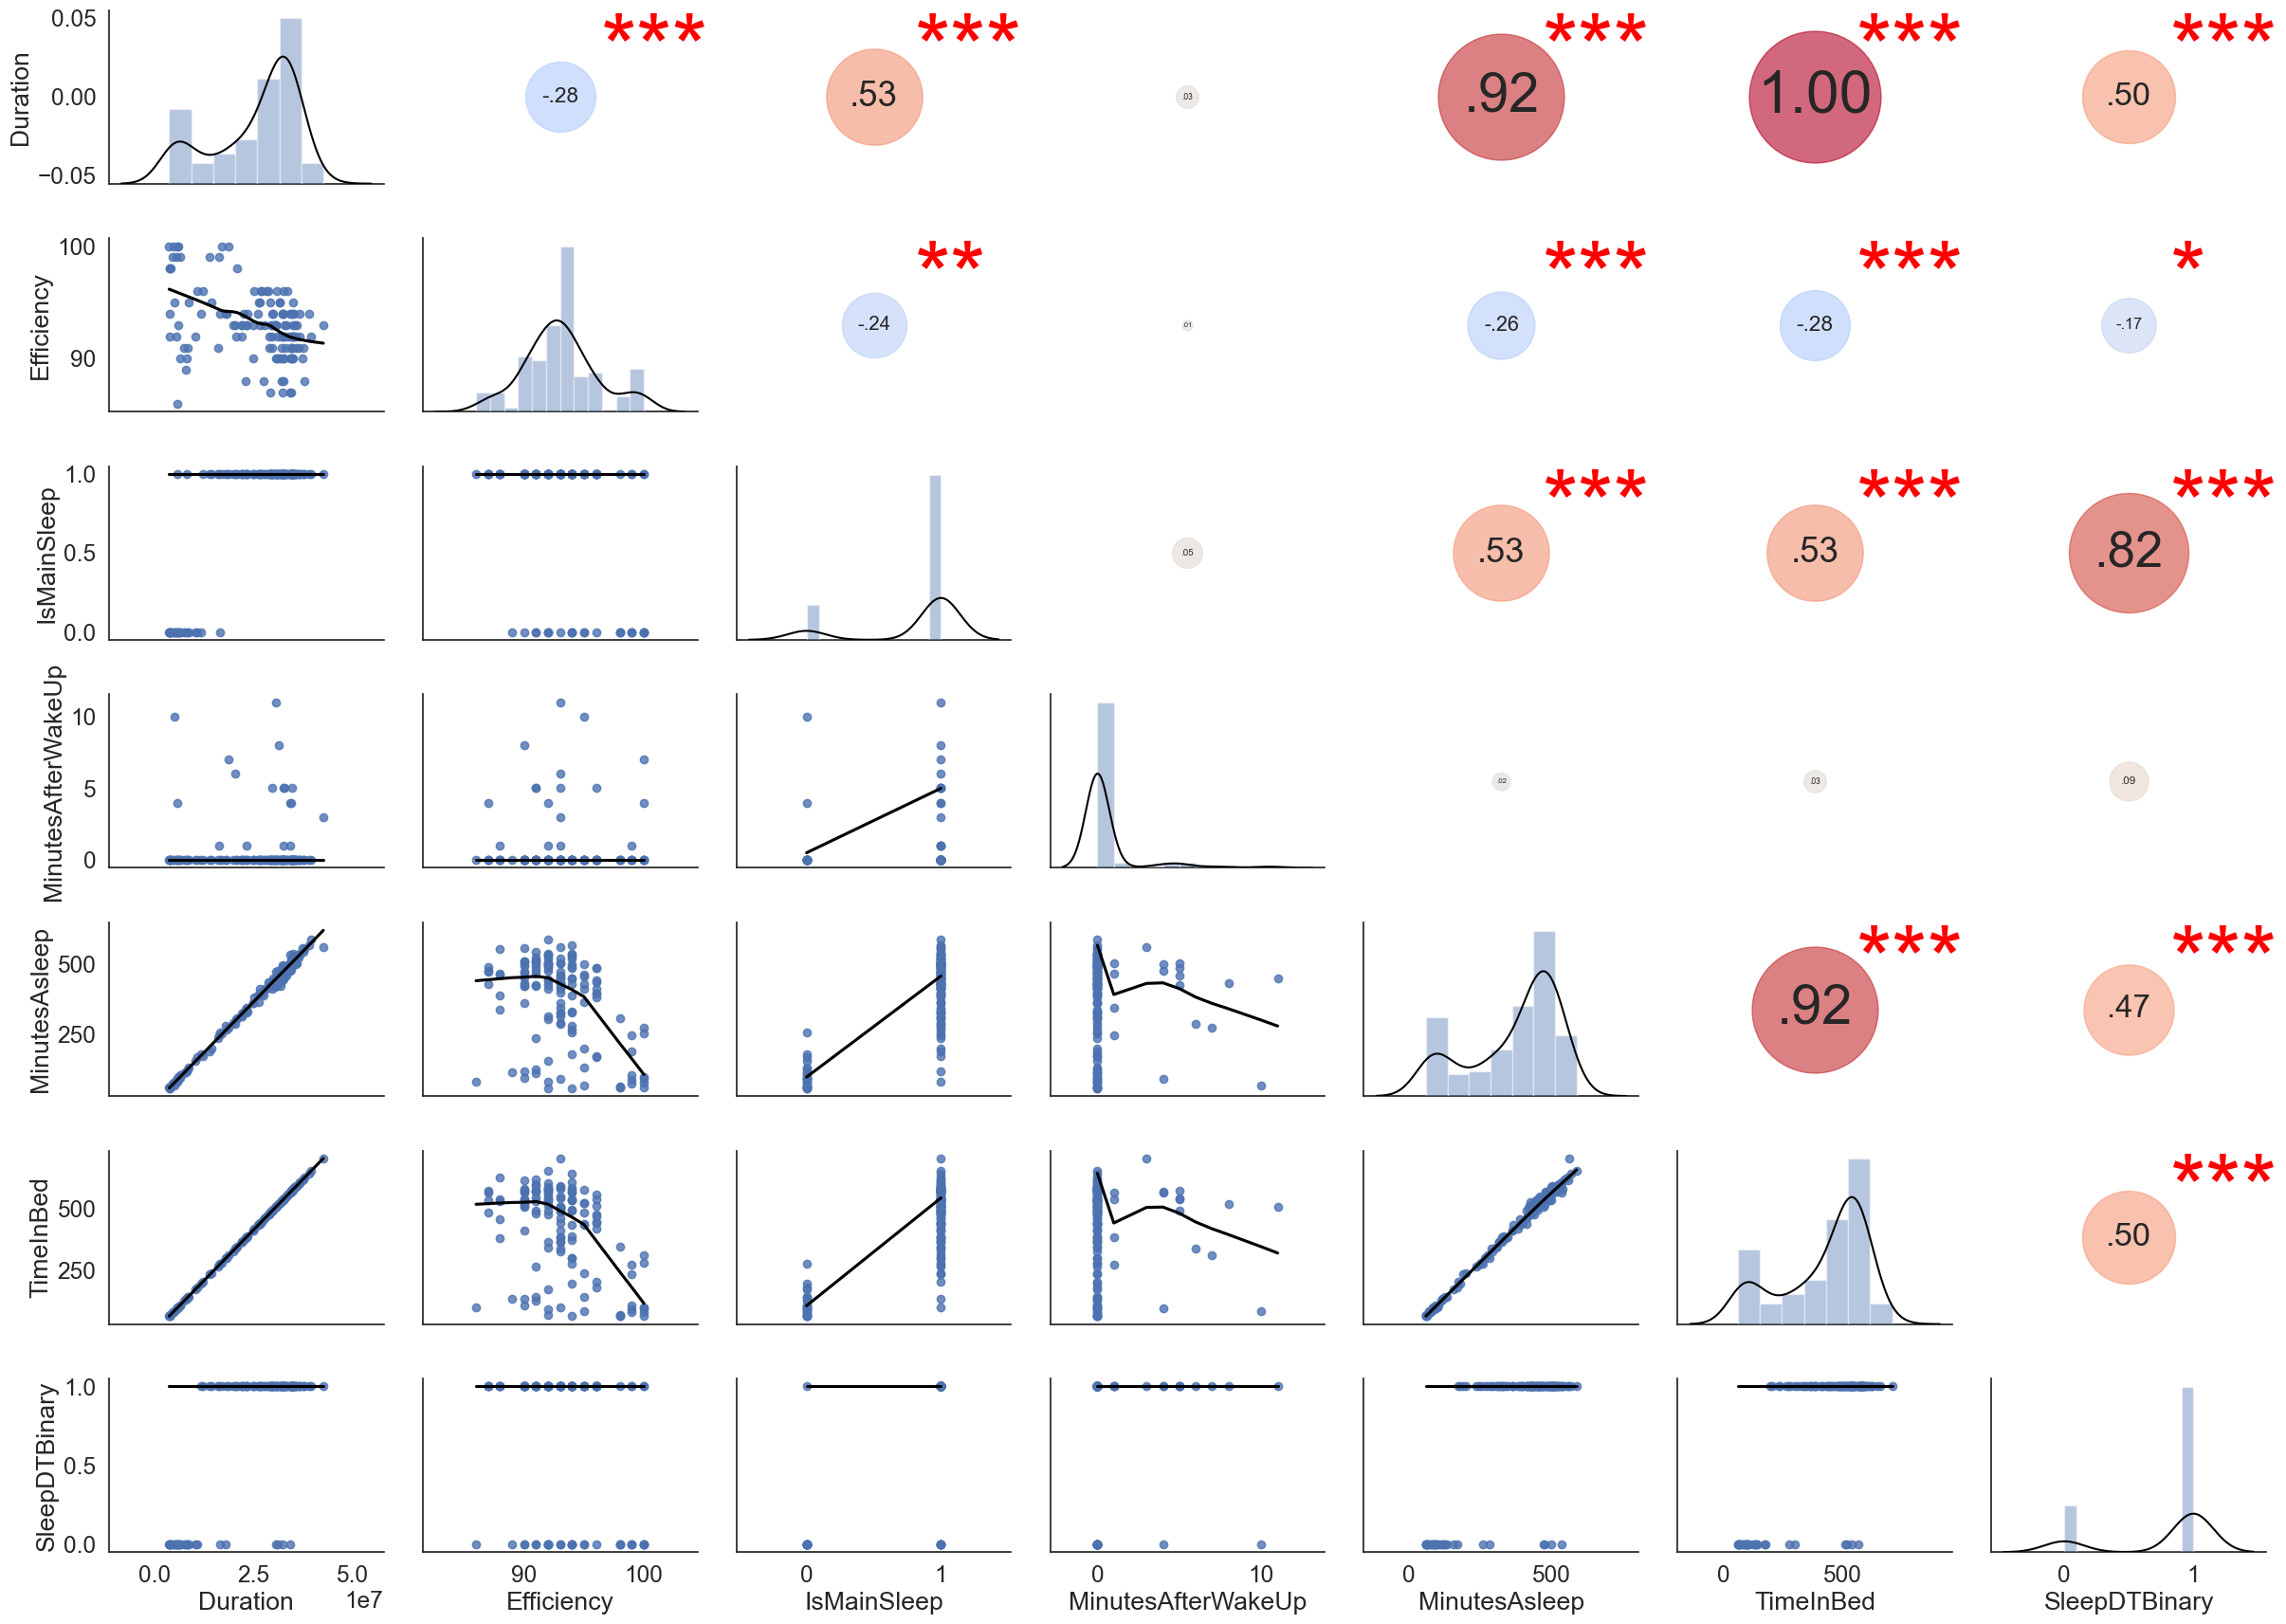

In [15]:
# let's see how well pairwise combinations of general features correlate with each other
pt_sleep_wear_scatter_all = pt_sleep_wear.iloc[:, [2, 3, 4, 6, 7, 9, 30]]

plotcorr(pt_sleep_wear_scatter_all)

plt.tight_layout()

save_fig((pt_id + "_scatter_plot_all"))

plt.show()

/Users/adityabehal/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/Users/adityabehal/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/Users/adityabehal/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/Users/adityabehal/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/Users/adityabehal/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.

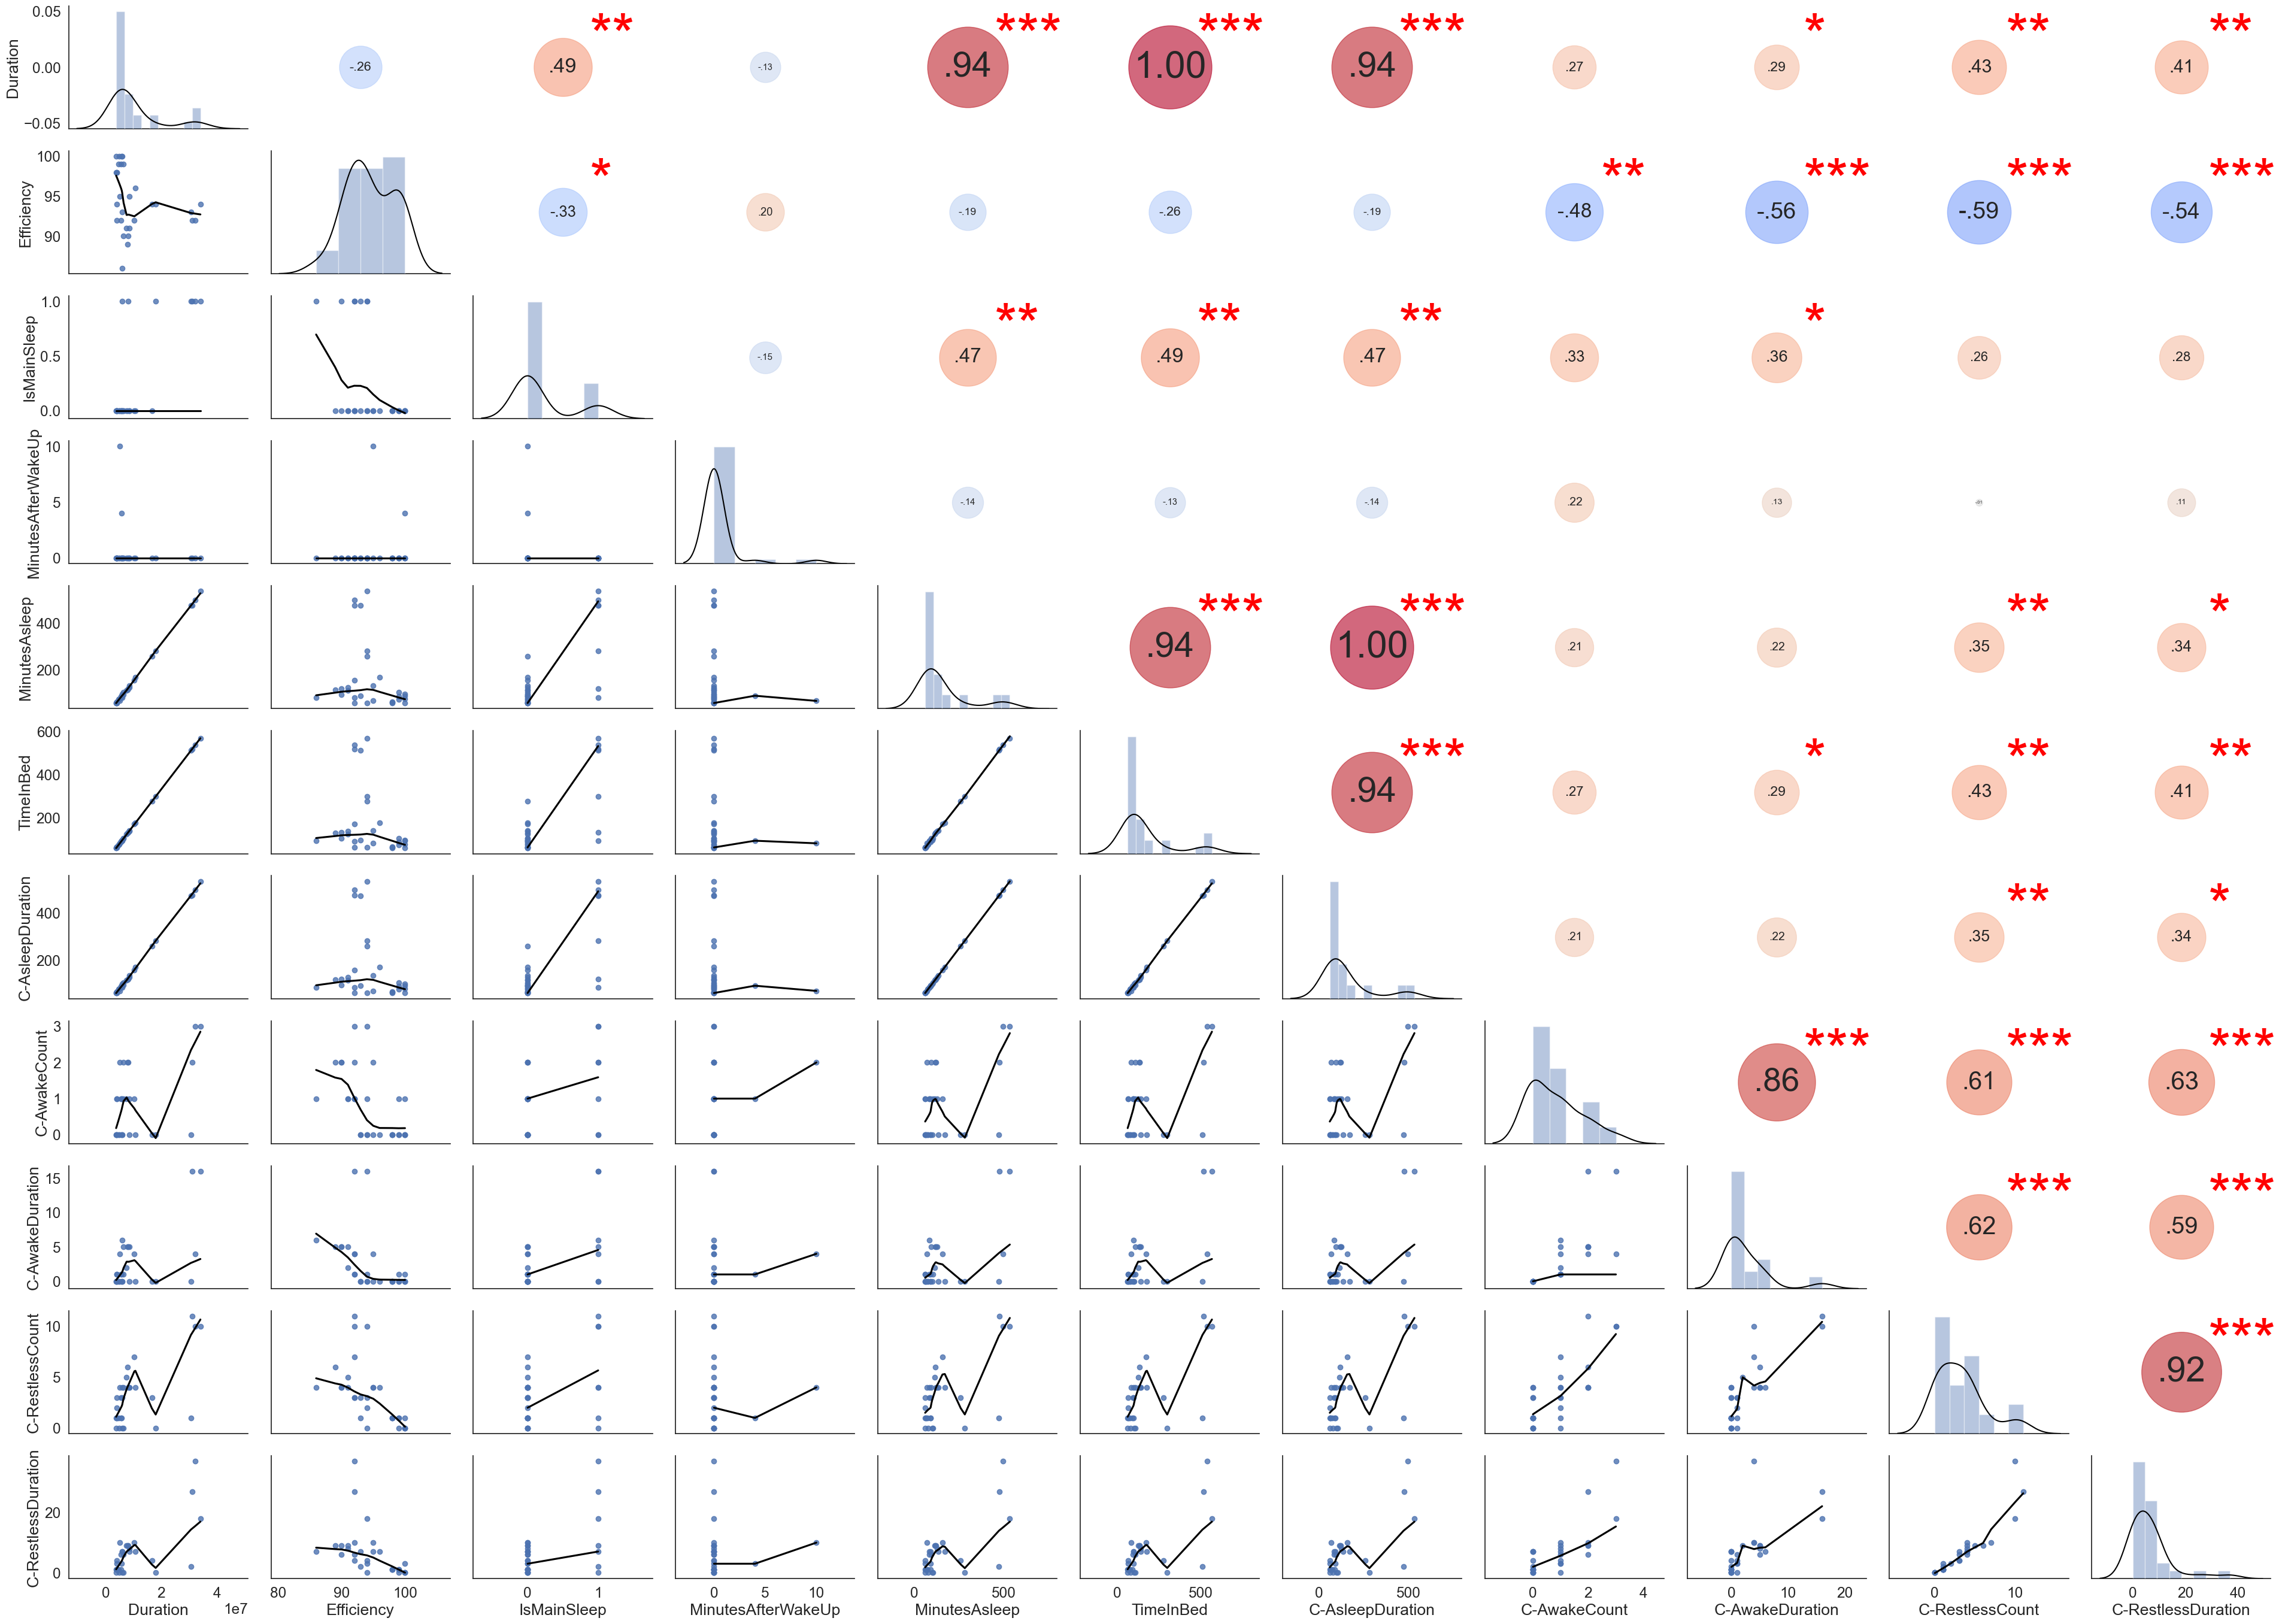

In [16]:
# let's see how well pairwise combinations of classic features correlate with each other
pt_sleep_wear_scatter_classic = pt_sleep_wear.iloc[:, [2, 3, 4, 6, 7, 9, 11, 12, 13, 14, 15]].dropna()

plotcorr(pt_sleep_wear_scatter_classic)

plt.tight_layout()

save_fig((pt_id + "_scatter_plot_classic"))

plt.show()

/Users/adityabehal/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/Users/adityabehal/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/Users/adityabehal/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/Users/adityabehal/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.py:227: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),
/Users/adityabehal/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/statsmodels/nonparametric/smoothers_lowess.

/Users/adityabehal/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/adityabehal/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/adityabehal/opt/anaconda3/envs/homl3/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use eith

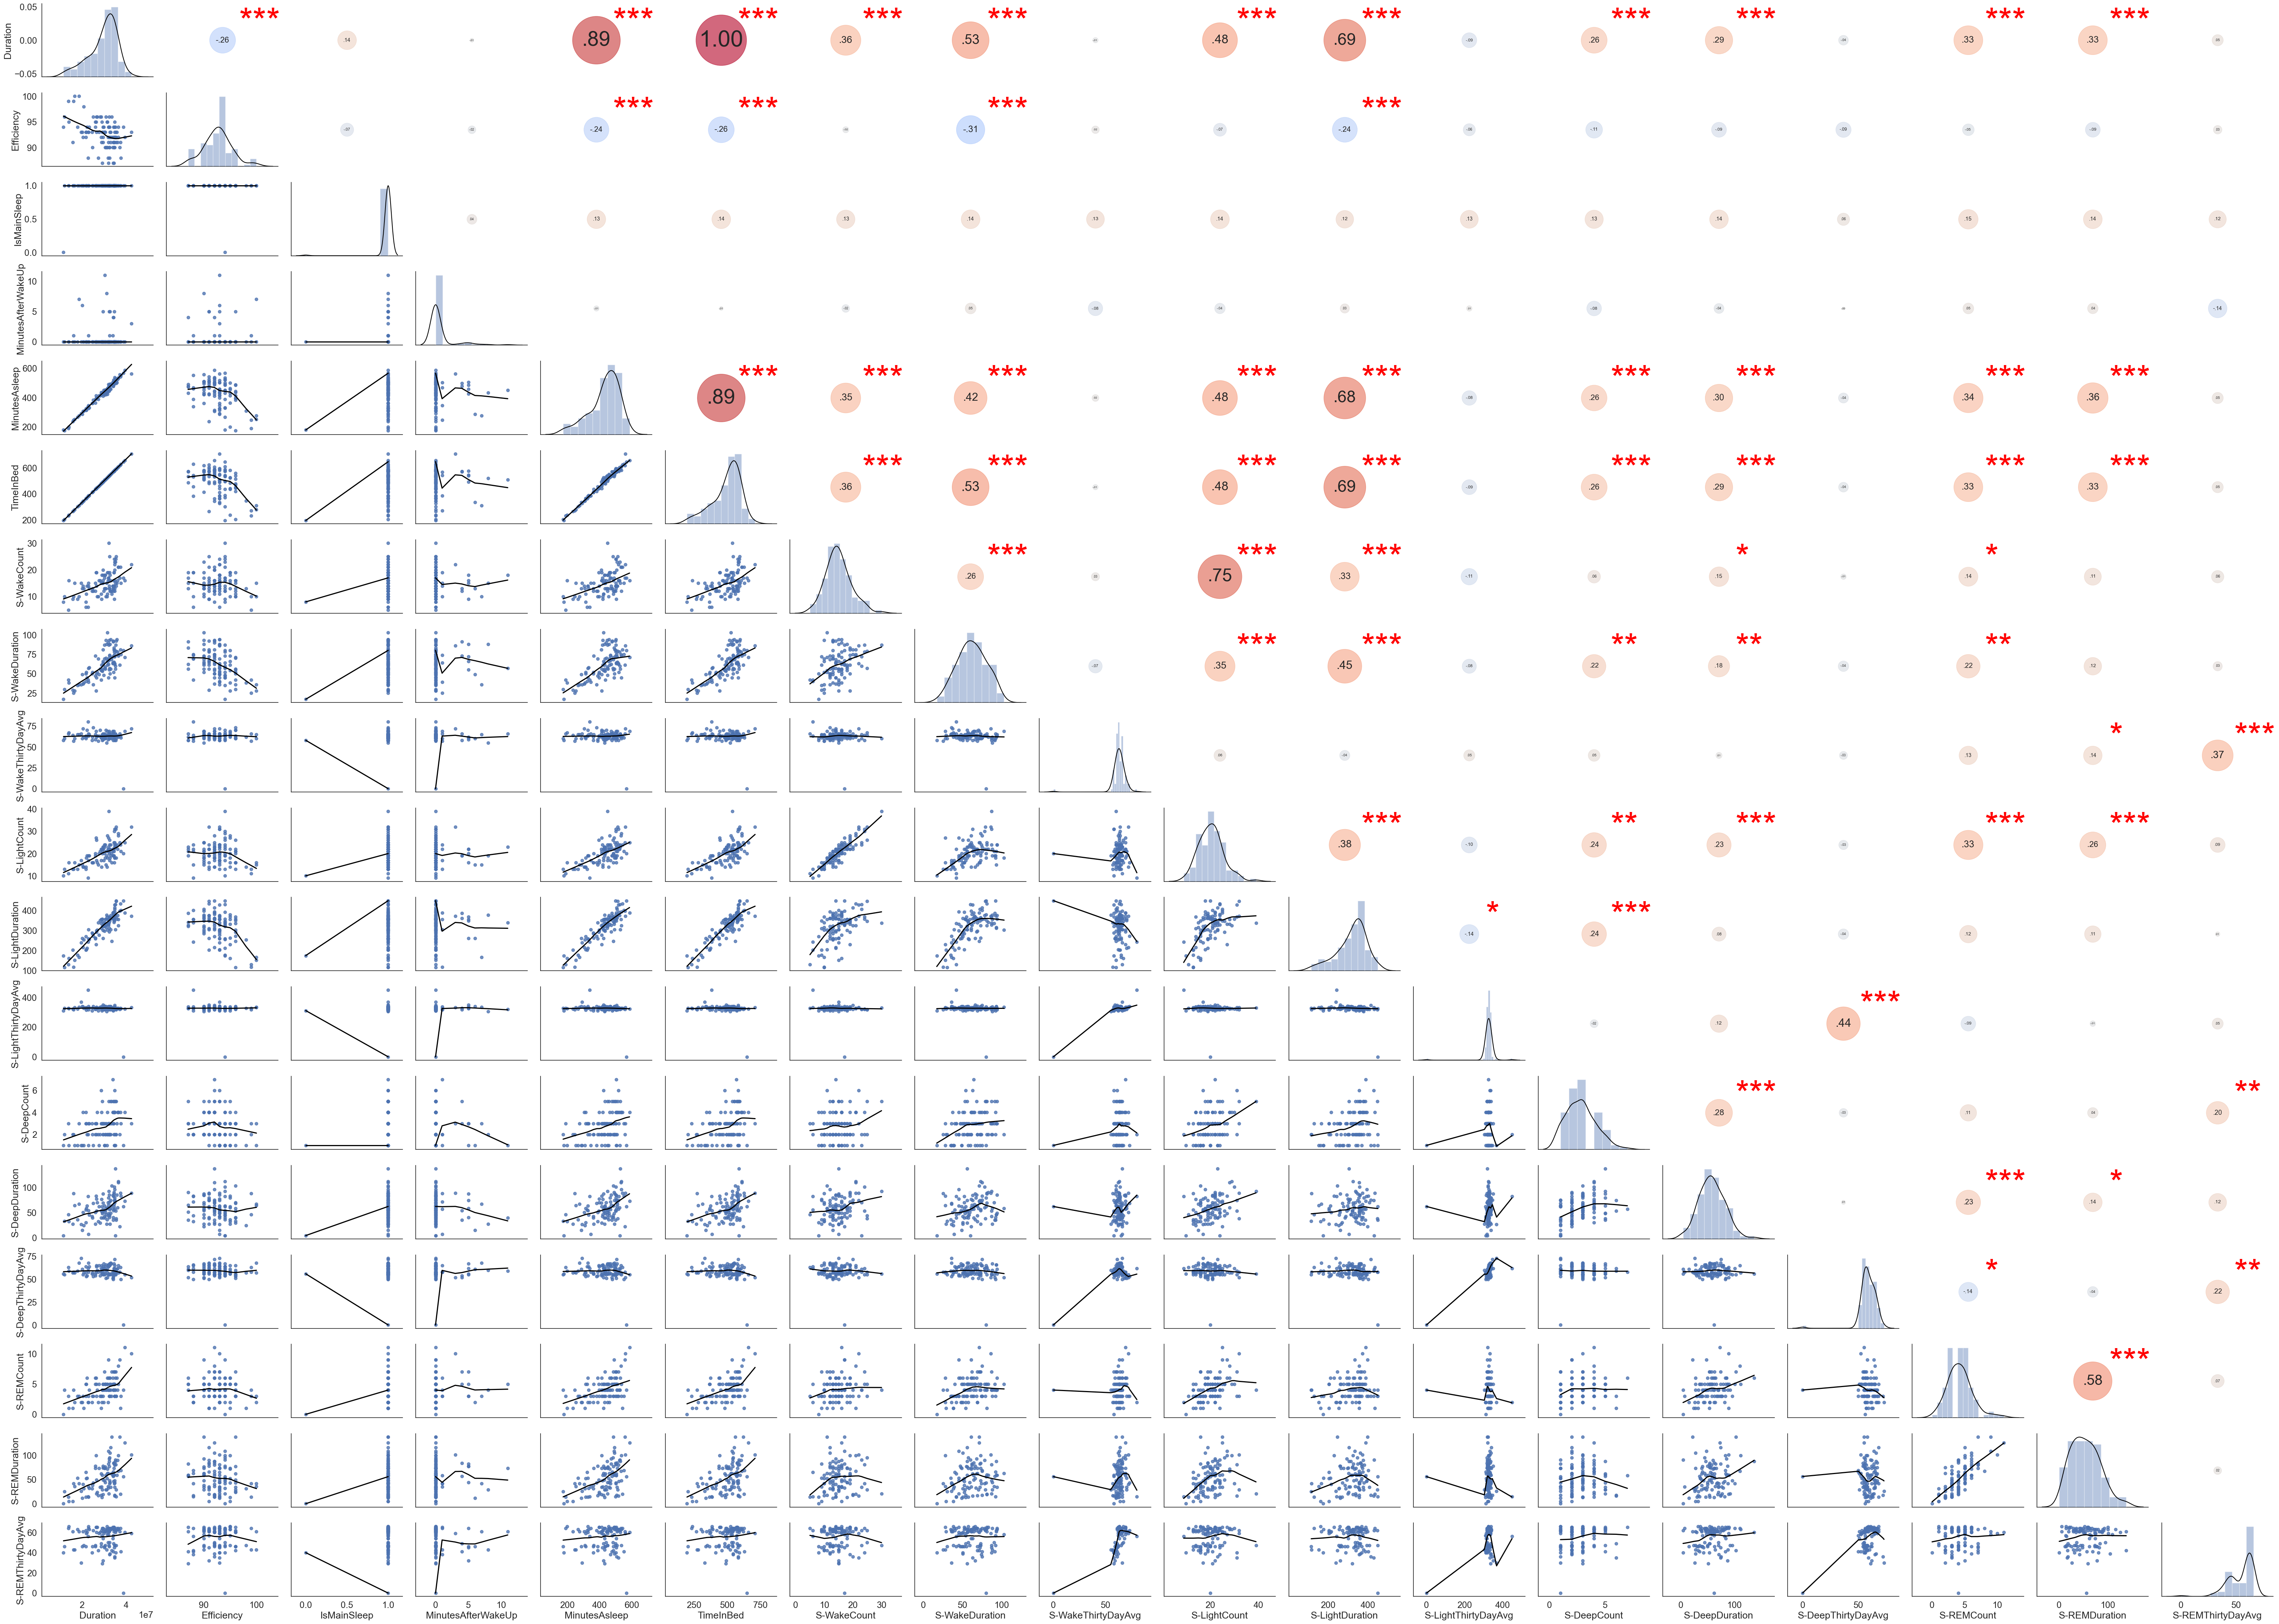

In [17]:
# let's see how well pairwise combinations of stages features correlate with each other
pt_sleep_wear_scatter_stages = pt_sleep_wear.iloc[:, [2, 3, 4, 6, 7, 9, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]].dropna()

plotcorr(pt_sleep_wear_scatter_stages)

plt.tight_layout()

save_fig((pt_id + "_scatter_plot_stages"))

plt.show()

In [18]:
# let's see if we can use general features to separate the data into high sleep and low sleep
pt_sleep_wear_scatter_clustered = pt_sleep_wear.iloc[:, [2, 3, 4, 6, 7, 9]]

# let's Z score each column across all the instances in our dataset to deal with outliers better
pt_sleep_wear_scatter_clustered = pd.DataFrame(StandardScaler().fit_transform(pt_sleep_wear_scatter_clustered), columns = pt_sleep_wear_scatter_clustered.columns)

# we will use a hierarchical clustering algorithm (hierarchical DBSCAN)
clusterer = hdbscan.HDBSCAN(min_cluster_size=10)
cluster_labels = clusterer.fit_predict(pt_sleep_wear_scatter_clustered)

pt_sleep_wear_scatter_clustered["cluster"] = cluster_labels.tolist()

In [19]:
# let's see the first 5 rows of the clustering results
pt_sleep_wear_scatter_clustered.head()

Duration  Efficiency  IsMainSleep  MinutesAfterWakeUp  MinutesAsleep  \
0  1.259169    0.307724     0.462910           -0.316119       1.272011   
1 -2.011815    0.307724    -2.160247           -0.316119      -2.023784   
2 -0.227642   -1.669466     0.462910           -0.316119      -0.203621   
3  0.888869   -0.351339     0.462910           -0.316119       0.875476   
4 -1.821054   -0.021807    -2.160247           -0.316119      -1.822266   

   TimeInBed  cluster  
0   1.259169        1  
1  -2.011815        0  
2  -0.227642        1  
3   0.888869        1  
4  -1.821054        0

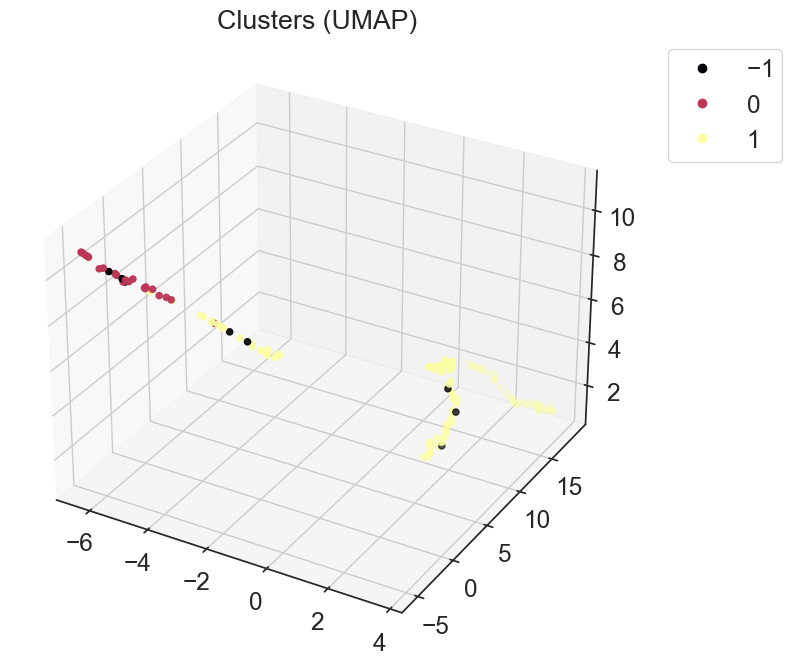

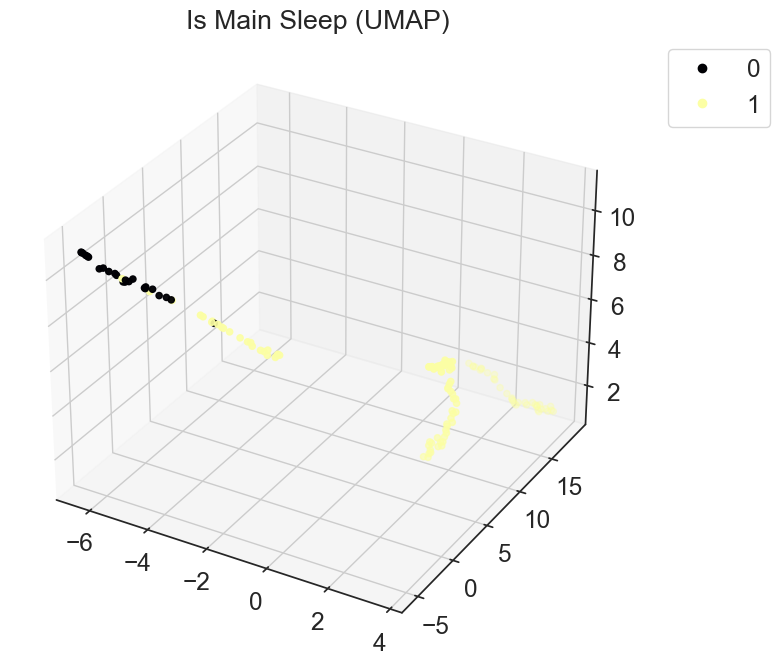

In [20]:
# let's visualize clusters and IsMainSleep in 3D using UMAP for nonlinear dimensionality reduction
pt_sleep_wear_scatter = pt_sleep_wear.iloc[:, [2, 3, 4, 6, 7, 9]]

umap_3d = UMAP(n_components=3, init='random', random_state=0)

proj_3d = umap_3d.fit_transform(pt_sleep_wear_scatter)

# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")

# Creating plot
sc = ax.scatter3D(proj_3d[:, 0], proj_3d[:, 1], proj_3d[:, 2], c=pt_sleep_wear_scatter_clustered["cluster"], cmap="inferno")
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)
plt.title("Clusters (UMAP)")

save_fig((pt_id + "_clusters_umap"))

# show plot
plt.show()

# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")

# Creating plot
sc = ax.scatter3D(proj_3d[:, 0], proj_3d[:, 1], proj_3d[:, 2], c=pt_sleep_wear["IsMainSleep"], cmap="inferno")
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)
plt.title("Is Main Sleep (UMAP)")

save_fig((pt_id + "_is_main_sleep_umap"))

# show plot
plt.show()

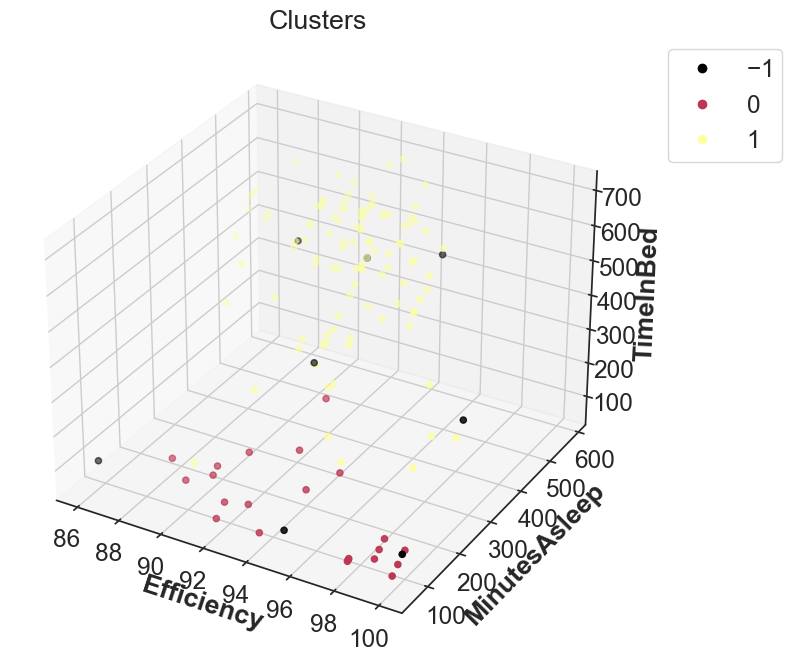

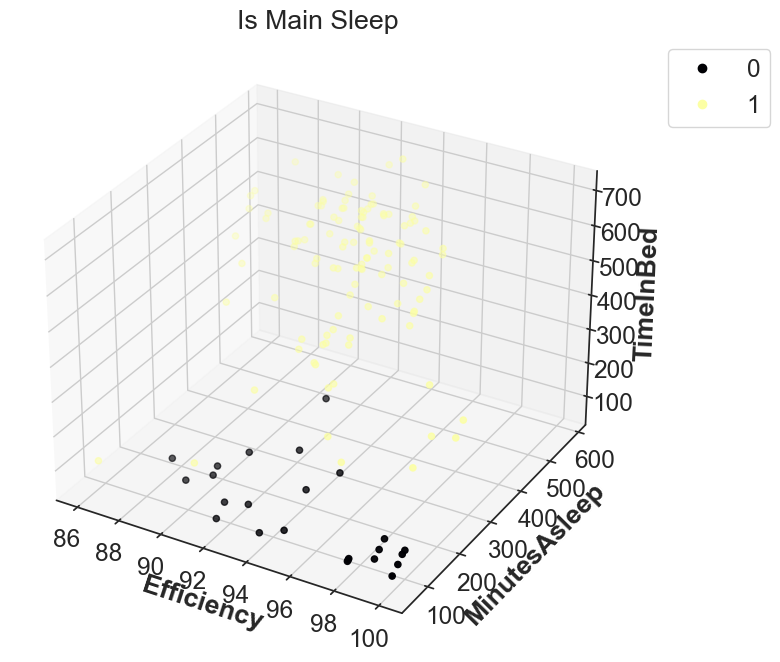

In [21]:
# let's visualize the clustering results in a 3D scatter plot with more concrete axes
pt_sleep_wear_scatter = pt_sleep_wear.iloc[:, [3, 7, 9]].to_numpy()

# Creating figure
fig = plt.figure(figsize = (10, 7))
plt.axes(projection='3d')
ax = fig.gca()

# Creating plot
sc = ax.scatter3D(pt_sleep_wear_scatter[:, 0], pt_sleep_wear_scatter[:, 1], pt_sleep_wear_scatter[:, 2], c=pt_sleep_wear_scatter_clustered["cluster"], cmap="inferno")
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)
plt.title("Clusters")

ax.set_xlabel(pt_sleep_wear.columns[3], fontweight ='bold')
ax.set_ylabel(pt_sleep_wear.columns[7], fontweight ='bold')
ax.set_zlabel(pt_sleep_wear.columns[9], fontweight ='bold')

save_fig((pt_id + "_clusters_3D_efficiency"))

# show plot
plt.show()

# Creating figure
fig = plt.figure(figsize = (10, 7))
plt.axes(projection='3d')
ax = fig.gca()

# Creating plot
sc = ax.scatter3D(pt_sleep_wear_scatter[:, 0], pt_sleep_wear_scatter[:, 1], pt_sleep_wear_scatter[:, 2], c=pt_sleep_wear["IsMainSleep"], cmap="inferno")
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)
plt.title("Is Main Sleep")

ax.set_xlabel(pt_sleep_wear.columns[3], fontweight ='bold')
ax.set_ylabel(pt_sleep_wear.columns[7], fontweight ='bold')
ax.set_zlabel(pt_sleep_wear.columns[9], fontweight ='bold')

save_fig((pt_id + "_is_main_sleep_3D_efficiency"))

# show plot
plt.show()

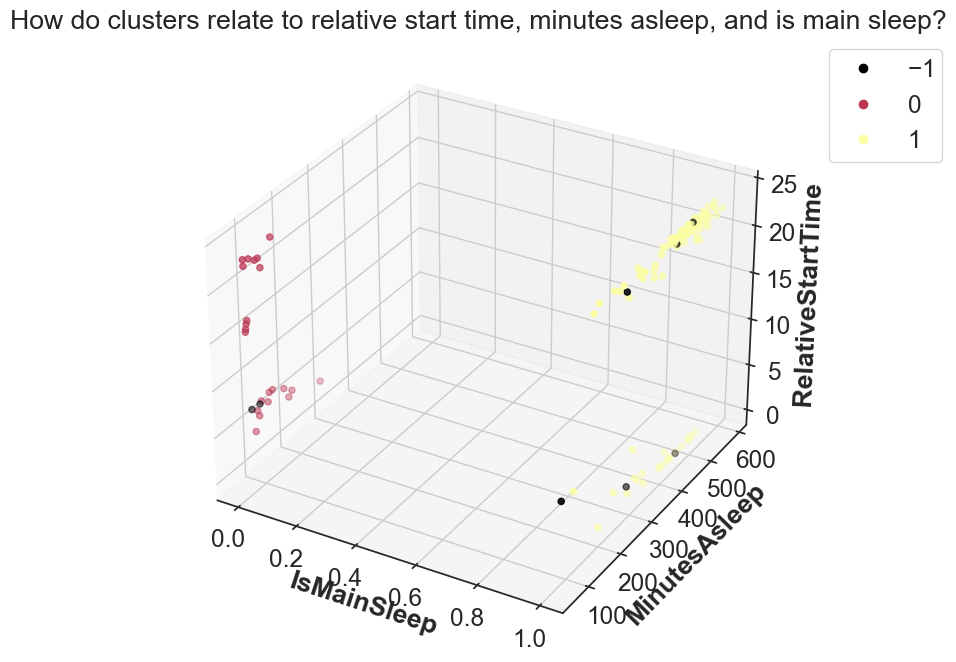

In [22]:
# How do clusters relate to relative start time, minutes asleep, and is main sleep?
pt_sleep_wear_scatter = pt_sleep_wear.iloc[:, [4, 7, 31]].to_numpy()

# Creating figure
fig = plt.figure(figsize = (10, 7))
plt.axes(projection='3d')
ax = fig.gca()

# Creating plot
sc = ax.scatter3D(pt_sleep_wear_scatter[:, 0], pt_sleep_wear_scatter[:, 1], pt_sleep_wear_scatter[:, 2], c=pt_sleep_wear_scatter_clustered["cluster"], cmap="inferno")
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)
plt.title("How do clusters relate to relative start time, minutes asleep, and is main sleep?")

ax.set_xlabel(pt_sleep_wear.columns[4], fontweight ='bold')
ax.set_ylabel(pt_sleep_wear.columns[7], fontweight ='bold')
ax.set_zlabel(pt_sleep_wear.columns[31], fontweight ='bold')

save_fig((pt_id + "_clusters_3D_relative_start_time"))

plt.show()

In [23]:
# let's calculate cluster fingerprints to see 
# if the clusters actually represent high and low sleep based on objective metrics
minClusterIndex = 0
maxClusterIndex = pt_sleep_wear_scatter_clustered["cluster"].max()

clusterFingerPrintsMeanZScore = pd.DataFrame()
clusterFingerPrintsStdZScore = pd.DataFrame()

for i in range(maxClusterIndex + 1):
    rowsOfInterest = pt_sleep_wear_scatter_clustered[pt_sleep_wear_scatter_clustered["cluster"] == i]
    
    clusterFingerPrintsMeanZScore["Cluster " + str(i)] = rowsOfInterest.loc[:, rowsOfInterest.columns != "cluster"].mean(axis=0)
    clusterFingerPrintsStdZScore["Cluster " + str(i)] = rowsOfInterest.loc[:, rowsOfInterest.columns != "cluster"].std(axis=0)

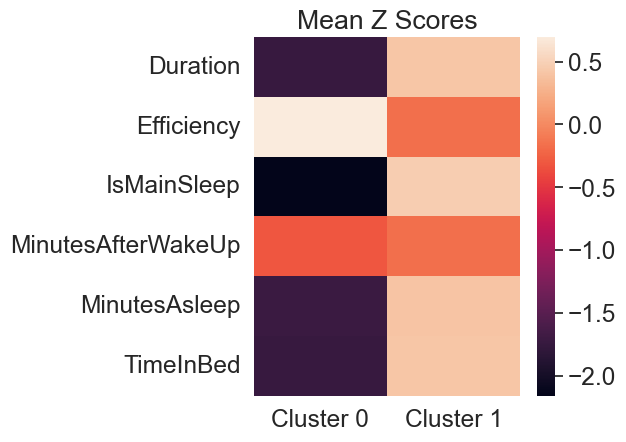

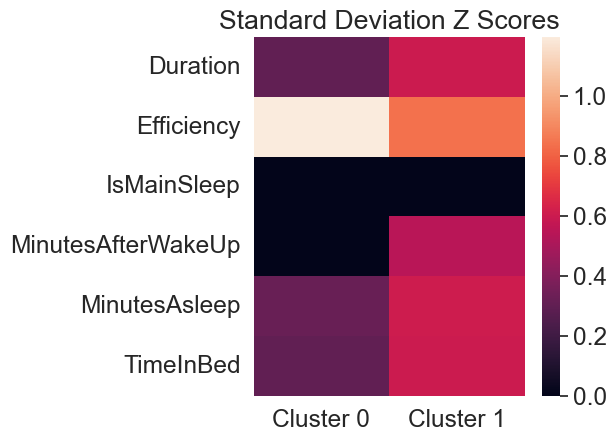

In [24]:
# plotting correlation heatmap
sns.heatmap(clusterFingerPrintsMeanZScore).set(title="Mean Z Scores")

save_fig((pt_id + "_cluster_fingerprints_mean_z_score"))

plt.show() 

sns.heatmap(clusterFingerPrintsStdZScore).set(title="Standard Deviation Z Scores")  

save_fig((pt_id + "_cluster_fingerprints_std_z_score"))

plt.show()